In [1]:
import os
os.chdir('../')

import warnings
warnings.filterwarnings('ignore')

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import os

!nvidia-smi
os.environ["CUDA_VISIBLE_DEVICES"]="6"

Mon Jan 22 02:39:00 2024       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.223.02   Driver Version: 470.223.02   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100 80G...  Off  | 00000000:1B:00.0 Off |                    0 |
| N/A   44C    P0    47W / 300W |     35MiB / 80994MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA A100 80G...  Off  | 00000000:1C:00.0 Off |                    0 |
| N/A   

### Model Parts

In [4]:
from model.main.enc_prior_latent_quantizer_dec import Model
from model.encoder.net_64_encoder import Encoder
from model.prior.dalle_randn_prior import Prior
from model.latent.dalle_lse_latent import Latent
from model.quantizer.dalle_nearest_quantizer import Quantizer
from model.decoder.net_64_decoder import Decoder

from tensorboardX import SummaryWriter
from util.util import *

### Model Init.

In [5]:
from easydict import EasyDict
hp = EasyDict()
hp.img_size = 64
hp.n_resblocks = 6
hp.z_dim = 64
hp.n_prior_embeddings = 512
hp.init_log_sigma = -2
hp.const_sigma = False
hp.quantize = False
hp.prior_mu = 0.99

In [6]:
step = 0
device = 'cuda:0'

model_list = []
optimizer_list = []
for i in range(1):
    model = Model(Encoder(**hp), Prior(**hp), Latent(**hp), Quantizer(**hp), Decoder(**hp))
    model = model.to(device)
    model_list.append(model)
    
    optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)
    optimizer_list.append(optimizer)

for name, module in model.named_modules():
    if len(name.split('.')) <= 2 and len(name) > 0:
        print(name, get_size(module))

print('done')

encoder 1.2191162109375
encoder.encoder 1.2191162109375
prior 0.126953125
latent 3.814697265625e-06
quantizer 0.0
decoder 1.0611686706542969
decoder.decoder 1.0611686706542969
done


### Load

In [7]:
save_dir = '/data/scpark/save/lse/train_dalle/train01.19-7_0.99_-2/'

!mkdir -p $save_dir
!ls -lt $save_dir

writer = SummaryWriter(save_dir)

if False:
    step, model_list, optimizer_list = load_model_list(save_dir, 9473, model_list, optimizer_list)

total 0


### Dataset

In [8]:
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import CelebA

class MyCelebA(CelebA):
    """
    A work-around to address issues with pytorch's celebA dataset class.
    
    Download and Extract
    URL : https://drive.google.com/file/d/1m8-EBPgi5MRubrm6iQjafK2QMHDBMSfJ/view?usp=sharing
    """
    
    def _check_integrity(self) -> bool:
        return True

root = '/data'
train_transforms = transforms.Compose([transforms.RandomHorizontalFlip(),
                                       transforms.CenterCrop(148),
                                       transforms.Resize(hp.img_size),
                                       transforms.ToTensor(),])
train_dataset = MyCelebA(root, split='train', transform=train_transforms, download=False)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
print('done')

done


In [9]:
def preprocess(batch):
    x, t = batch
    data = {}
    data['x'] = x.to(device)
    data['t'] = t.to(device)
    return data

### Train

In [10]:
def plot(x):
    _x = x.permute(0, 2, 3, 1).data.cpu().numpy()
    plt.figure(figsize=[18, 4])
    for i in range(8):
        plt.subplot(1, 8, i+1)
        plt.imshow(_x[i])
        plt.xticks([])
        plt.yticks([])
    plt.show()

In [11]:
def linear(start_value, end_value, current_index, start_index, end_index):
    if current_index > end_index:
        return end_value
    if current_index < start_index:
        return start_value

    grad = (end_value - start_value) / (end_index - start_index)
    y = start_value + grad * (current_index - start_index)

    return y

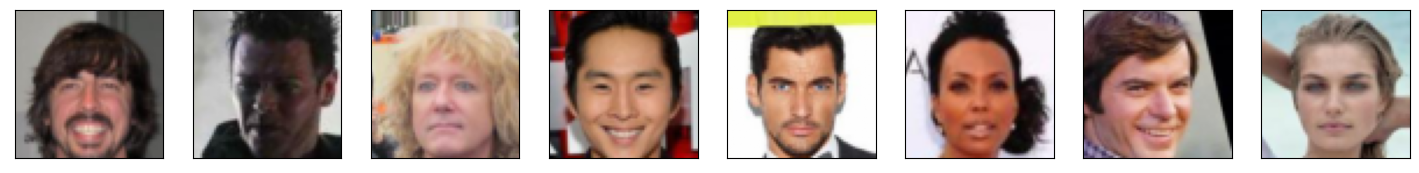

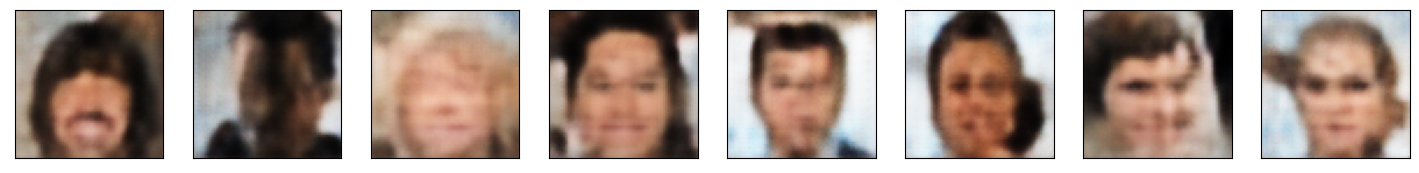

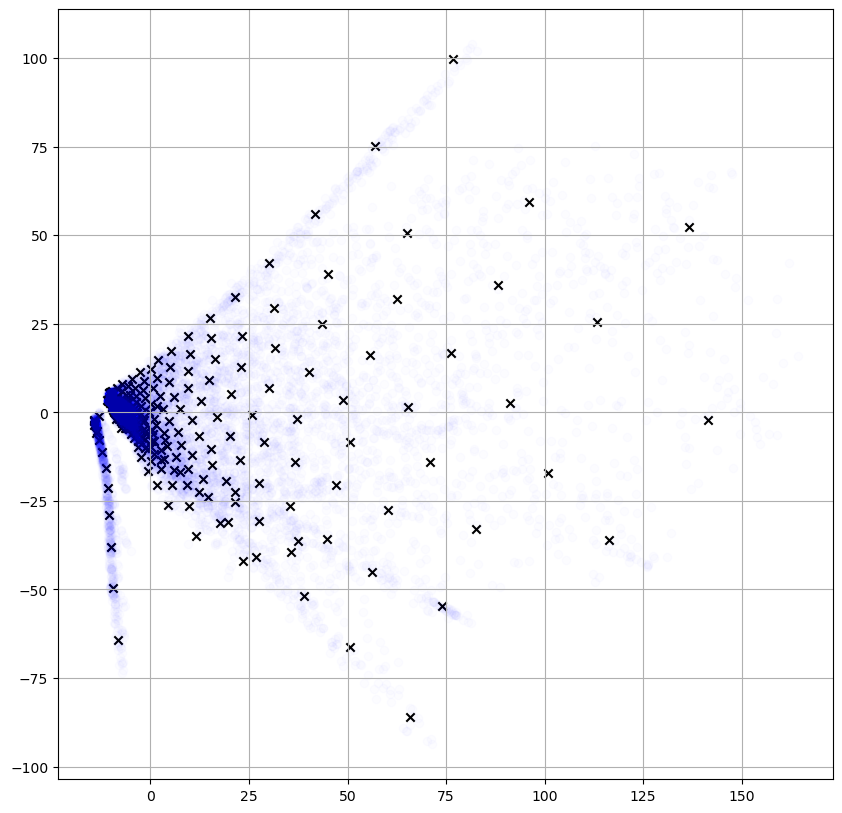

7001
lse_loss -134.73046875
commit_loss 0.18825209140777588
recon_loss 0.009589385241270065
7002
lse_loss -136.06251525878906
commit_loss 0.1888662427663803
recon_loss 0.008148066699504852
7003
lse_loss -136.79270935058594
commit_loss 0.20076991617679596
recon_loss 0.007716234773397446
7004
lse_loss -136.6032257080078
commit_loss 0.18206176161766052
recon_loss 0.009325849823653698
7005
lse_loss -137.4069366455078
commit_loss 0.1822202205657959
recon_loss 0.00855595339089632
7006
lse_loss -135.52915954589844
commit_loss 0.1979619711637497
recon_loss 0.008565389551222324
7007
lse_loss -138.05137634277344
commit_loss 0.1816730499267578
recon_loss 0.007751173339784145
7008
lse_loss -134.0968475341797
commit_loss 0.18238285183906555
recon_loss 0.009298726916313171
7009
lse_loss -137.22161865234375
commit_loss 0.17281317710876465
recon_loss 0.008787817321717739
7010
lse_loss -138.8837432861328
commit_loss 0.1867048442363739
recon_loss 0.00868668220937252
7011
lse_loss -134.87428283691406
com

7086
lse_loss -137.06060791015625
commit_loss 0.2271071970462799
recon_loss 0.008317254483699799
7087
lse_loss -137.6380615234375
commit_loss 0.18381819128990173
recon_loss 0.008160913363099098
7088
lse_loss -137.4307861328125
commit_loss 0.19156861305236816
recon_loss 0.00791881512850523
7089
lse_loss -137.19273376464844
commit_loss 0.2641693949699402
recon_loss 0.009808684699237347
7090
lse_loss -135.49803161621094
commit_loss 0.23899993300437927
recon_loss 0.008263207040727139
7091
lse_loss -137.14096069335938
commit_loss 0.20763415098190308
recon_loss 0.008085926994681358
7092
lse_loss -135.97869873046875
commit_loss 0.18924424052238464
recon_loss 0.008973116986453533
7093
lse_loss -135.53509521484375
commit_loss 0.21085718274116516
recon_loss 0.008662045001983643
7094
lse_loss -137.44068908691406
commit_loss 0.22786051034927368
recon_loss 0.008029507473111153
7095
lse_loss -140.107421875
commit_loss 0.19041693210601807
recon_loss 0.00810498557984829
7096
lse_loss -135.755310058593

7171
lse_loss -136.2298583984375
commit_loss 0.18729561567306519
recon_loss 0.008568212389945984
7172
lse_loss -137.46644592285156
commit_loss 0.18487870693206787
recon_loss 0.008801933377981186
7173
lse_loss -139.4829864501953
commit_loss 0.18090033531188965
recon_loss 0.008035770617425442
7174
lse_loss -137.54434204101562
commit_loss 0.17697773873806
recon_loss 0.00748797133564949
7175
lse_loss -136.50758361816406
commit_loss 0.202914759516716
recon_loss 0.00845516286790371
7176
lse_loss -139.50704956054688
commit_loss 0.17848770320415497
recon_loss 0.008018085733056068
7177
lse_loss -138.5166473388672
commit_loss 0.1808215230703354
recon_loss 0.008081655949354172
7178
lse_loss -138.21214294433594
commit_loss 0.18893028795719147
recon_loss 0.008160454221069813
7179
lse_loss -136.552734375
commit_loss 0.1919778734445572
recon_loss 0.009048853069543839
7180
lse_loss -133.22271728515625
commit_loss 0.2029646784067154
recon_loss 0.009201912209391594
7181
lse_loss -138.41970825195312
comm

7256
lse_loss -133.6226348876953
commit_loss 0.20201736688613892
recon_loss 0.008806332014501095
7257
lse_loss -139.2419891357422
commit_loss 0.18204635381698608
recon_loss 0.008459243923425674
7258
lse_loss -132.317626953125
commit_loss 0.2071554958820343
recon_loss 0.008640971034765244
7259
lse_loss -134.7577667236328
commit_loss 0.20581302046775818
recon_loss 0.009501675143837929
7260
lse_loss -136.81529235839844
commit_loss 0.19421014189720154
recon_loss 0.008749167434871197
7261
lse_loss -135.7452392578125
commit_loss 0.1866665929555893
recon_loss 0.008433807641267776
7262
lse_loss -139.3832550048828
commit_loss 0.18587626516819
recon_loss 0.007776707410812378
7263
lse_loss -135.92710876464844
commit_loss 0.2075212299823761
recon_loss 0.008641375228762627
7264
lse_loss -138.8894805908203
commit_loss 0.20139144361019135
recon_loss 0.009205895476043224
7265
lse_loss -139.438720703125
commit_loss 0.1840897649526596
recon_loss 0.008121160790324211
7266
lse_loss -139.67236328125
commit

7341
lse_loss -135.5506591796875
commit_loss 0.2416512668132782
recon_loss 0.008355394937098026
7342
lse_loss -137.5298309326172
commit_loss 0.21185138821601868
recon_loss 0.009486870840191841
7343
lse_loss -138.04612731933594
commit_loss 0.22914929687976837
recon_loss 0.009421264752745628
7344
lse_loss -139.96145629882812
commit_loss 0.2508664131164551
recon_loss 0.008767354302108288
7345
lse_loss -131.09080505371094
commit_loss 0.33764857053756714
recon_loss 0.010955281555652618
7346
lse_loss -138.4066925048828
commit_loss 0.24902477860450745
recon_loss 0.008364544250071049
7347
lse_loss -135.0050506591797
commit_loss 0.2679077982902527
recon_loss 0.008927087299525738
7348
lse_loss -135.90394592285156
commit_loss 0.21897044777870178
recon_loss 0.008970916271209717
7349
lse_loss -138.64076232910156
commit_loss 0.2180936634540558
recon_loss 0.007963521406054497
7350
lse_loss -139.7811737060547
commit_loss 0.26462143659591675
recon_loss 0.009554356336593628
7351
lse_loss -134.3909454345

lse_loss -133.79685974121094
commit_loss 0.23375573754310608
recon_loss 0.00993400625884533
7427
lse_loss -139.4085235595703
commit_loss 0.20160678029060364
recon_loss 0.008829250931739807
7428
lse_loss -138.12083435058594
commit_loss 0.18928754329681396
recon_loss 0.00904882326722145
7429
lse_loss -137.17172241210938
commit_loss 0.23730029165744781
recon_loss 0.008299941197037697
7430
lse_loss -137.1328125
commit_loss 0.24351578950881958
recon_loss 0.008854348212480545
7431
lse_loss -133.97003173828125
commit_loss 0.26190483570098877
recon_loss 0.008506642654538155
7432
lse_loss -139.47573852539062
commit_loss 0.20345726609230042
recon_loss 0.009140769019722939
7433
lse_loss -140.2337188720703
commit_loss 0.1912766993045807
recon_loss 0.008965603075921535
7434
lse_loss -136.3020477294922
commit_loss 0.2263457030057907
recon_loss 0.008081801235675812
7435
lse_loss -138.489501953125
commit_loss 0.20760884881019592
recon_loss 0.00862814486026764
7436
lse_loss -137.52578735351562
commit_l

7512
lse_loss -135.5838165283203
commit_loss 0.21567416191101074
recon_loss 0.008702927269041538
7513
lse_loss -137.4068145751953
commit_loss 0.1882508397102356
recon_loss 0.00889874342828989
7514
lse_loss -136.98826599121094
commit_loss 0.19221460819244385
recon_loss 0.008522653952240944
7515
lse_loss -139.90318298339844
commit_loss 0.2354270964860916
recon_loss 0.010862442664802074
7516
lse_loss -137.000732421875
commit_loss 0.2125645875930786
recon_loss 0.007545302622020245
7517
lse_loss -137.6925811767578
commit_loss 0.214528888463974
recon_loss 0.00846901535987854
7518
lse_loss -138.21871948242188
commit_loss 0.22595521807670593
recon_loss 0.008156513795256615
7519
lse_loss -136.57981872558594
commit_loss 0.23218697309494019
recon_loss 0.008268356323242188
7520
lse_loss -140.18182373046875
commit_loss 0.18603961169719696
recon_loss 0.008039196021854877
7521
lse_loss -137.5081024169922
commit_loss 0.19203868508338928
recon_loss 0.009006825275719166
7522
lse_loss -136.71820068359375

In [ ]:
from IPython import display

while True:
    for batch in train_loader:
        print(step)
        
        loss_dict = {}
        for model, optimizer in zip(model_list, optimizer_list):
            data = preprocess(batch)

            # Forward
            model.train()
            model.zero_grad()
            data = model(data, latent_temp=1)

            # Backward
            loss = 0
            for key in data.keys():
                if 'lse_loss' in key:
                    loss = loss + data[key]
                    if key in loss_dict:
                        loss_dict[key].append(data[key].item())
                    else:
                        loss_dict[key] = [data[key].item()]
                elif 'commit_loss' in key:
                    loss = loss + data[key] * 0
                    if key in loss_dict:
                        loss_dict[key].append(data[key].item())
                    else:
                        loss_dict[key] = [data[key].item()]        
                elif 'loss' in key:
                    loss = loss + data[key]
                    if key in loss_dict:
                        loss_dict[key].append(data[key].item())
                    else:
                        loss_dict[key] = [data[key].item()]
                    
            loss.backward()
            optimizer.step()
            
        for key in loss_dict:
            writer.add_scalar(key, np.mean(loss_dict[key]), step)
            print(key, np.mean(loss_dict[key]))
        
        if step % 1000 == 0:
            import matplotlib.pyplot as plt
            display.clear_output()
            
            x = data['x']
            y = data['y']
            
            plot(x)
            plot(y)
            
            from sklearn.decomposition import PCA
            pca = PCA(n_components=2)
            e = model.prior.prior.data.cpu().numpy()
            pca.fit(e)
            e_pca = pca.transform(e)
            z_pca = pca.transform(data['z'].permute(0, 2, 3, 1).reshape(-1, hp.z_dim).data.cpu().numpy())
            plt.figure(figsize=[10, 10])
            plt.scatter(e_pca[:, 0], e_pca[:, 1], marker='x', alpha=1.0, color='black')
            plt.scatter(z_pca[:, 0], z_pca[:, 1], marker='o', alpha=0.01, color='blue')
            plt.grid()
            plt.show() 
            
        if step % 10000 == 0:
            save_model_list(save_dir, step, model_list, optimizer_list)
                
        step += 1
        

In [ ]:
save_model_list(save_dir, step, model_list, optimizer_list)
print('done')